# Apply correction factor to Voyager data (for real)

CORRELATION LENGTH = 17 DAYS

In [1]:
import numpy as np
import pandas as pd
import math as m
import pickle
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.dates as mdates

import sys
import os

sys.path.append(os.path.abspath(".."))
# So that I can read in the src files while working here in the notebooks/ folder

In [2]:
import src.utils as utils
import src.params as params
import src.sf_funcs as sf

# Set matplotlib font size
plt.rc("text", usetex=True)
plt.rc("font", family="serif", serif="Computer Modern", size=10)

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

In [3]:
# Read in cleaned Voyager 1 data
df = pd.read_pickle("../data/interim/voyager/voyager1_lism_cleaned.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7461001 entries, 2012-08-25 00:00:00 to 2023-12-31 00:00:00
Freq: 48s
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   F1      float32
 1   BR      float32
 2   BT      float32
 3   BN      float32
dtypes: float32(4)
memory usage: 170.8 MB


<Axes: >

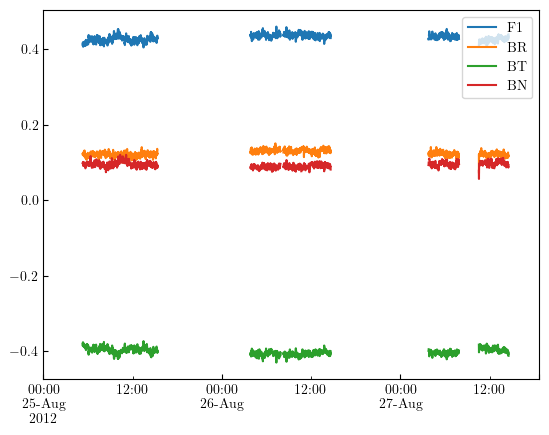

In [4]:
df[:5000].plot()

In [5]:
# Proportion of missing data
print(df.isna().sum() / len(df["F1"]))

F1    0.723359
BR    0.723359
BT    0.723359
BN    0.723359
dtype: float64


## Extract interval D1

In [6]:
# Extract a 170-day interval using a datetime offset
start_date = pd.Timestamp("2012-08-15")
end_date = start_date + pd.DateOffset(days=170)
int = df[start_date:end_date]

int.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288001 entries, 2012-08-25 00:00:00 to 2013-02-01 00:00:00
Freq: 48s
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      68334 non-null  float32
 1   BR      68334 non-null  float32
 2   BT      68334 non-null  float32
 3   BN      68334 non-null  float32
dtypes: float32(4)
memory usage: 6.6 MB


## Computing standardised SFs

i.e. from intervals of 10,000 points across 10 correlation lengths, calculated up to lag 2,000.
Integral corr length `tc` has already been defined above.

In [7]:
tc = 17 * 24 * 3600  # (17 days in seconds)

tc_n = 10
interval_length = params.int_length
new_cadence = tc_n * tc / interval_length

lags = np.arange(1, params.max_lag_prop * params.int_length)
powers = [2]
file_index = 0
int_index = 1
version = 0

In [8]:
df_std = df.resample(str(np.round(new_cadence, 3)) + "s").mean()
df_std.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 243824 entries, 2012-08-25 00:00:00 to 2023-12-30 23:47:02.400000
Freq: 1468800ms
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      75169 non-null  float32
 1   BR      75169 non-null  float32
 2   BT      75169 non-null  float32
 3   BN      75169 non-null  float32
dtypes: float32(4)
memory usage: 5.6 MB


In [9]:
m.floor(len(df_std) / interval_length)

24

We should have 24 intervals of 10,000 points each, each covering 10 correlation times.

In [10]:
del df

In [11]:
# Extract an interval
int_std = df_std[int_index * interval_length : (int_index + 1) * interval_length]
int_std.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10000 entries, 2013-02-11 00:00:00 to 2013-07-30 23:35:31.200000
Freq: 1468800ms
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      5151 non-null   float32
 1   BR      5151 non-null   float32
 2   BT      5151 non-null   float32
 3   BN      5151 non-null   float32
dtypes: float32(4)
memory usage: 234.4 KB


In [12]:
int_std.describe()

,F1,BR,BT,BN
count,5151.000000,5151.000000,5151.000000,5151.000000
mean,0.484269,0.166058,-0.414536,0.186757
std,0.021206,0.013827,0.016211,0.012505
min,0.432701,0.136968,-0.470344,0.146487
25%,0.466245,0.154028,-0.425772,0.177678
50%,0.481086,0.162758,-0.412990,0.186111
75%,0.500390,0.178727,-0.402266,0.194836
max,0.551955,0.197870,-0.379098,0.228625


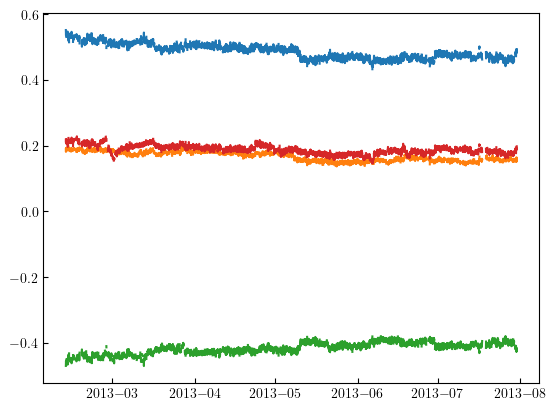

In [13]:
plt.plot(int_std)

In [14]:
int_norm = utils.normalize(int_std)
bad_input = int_norm[["BR", "BT", "BN"]]
bad_input.describe()

,BR,BT,BN
count,5151.000000,5151.000000,5151.000000
mean,4.369652,-32.087841,6.486774
std,1.000000,1.000000,1.000000
min,2.265858,-35.530445,3.266614
25%,3.499678,-32.780930,5.760789
50%,4.131006,-31.992422,6.435170
75%,5.285852,-31.330910,7.132823
max,6.670300,-29.901730,9.834742


In [15]:
print("Fraction missing:")

print(bad_input.isna().sum() / len(bad_input["BR"]))

missing = bad_input["BR"].isna().sum() / len(bad_input["BR"])

Fraction missing:
BR    0.4849
BT    0.4849
BN    0.4849
dtype: float64


In [16]:
bad_output = sf.compute_sf(bad_input, lags, powers, False, False)
bad_output["gap_handling"] = "naive"
bad_output["file_index"] = file_index
bad_output["int_index"] = int_index
bad_output["version"] = version

In [17]:
interp_input = (
    bad_input.interpolate(method="linear").ffill().bfill()
)  # Linearly interpolate (and, in case of missing values at edges, back and forward fill)
interp_output = sf.compute_sf(interp_input, lags, powers, False, False)

In [18]:
interp_input_df = pd.DataFrame(interp_input)
interp_input_df.reset_index(inplace=True)  # Make time a column, not an index

interp_output["file_index"] = 0
interp_output["int_index"] = int_index
interp_output["version"] = 0
interp_output["gap_handling"] = "lint"

# Correcting sample size and uncertainty for linear interpolation, same values as no handling
interp_output["n"] = bad_output["n"]
interp_output["missing_percent"] = bad_output["missing_percent"]
interp_output["sf_2_se"] = bad_output["sf_2_se"]

In [19]:
n_bins = 25
run_mode = "full"

sfs_gapped = pd.concat([interp_output, bad_output])

In [20]:
sfs_gapped.head()

,lag,n,missing_percent,sf_2,sf_2_se,file_index,int_index,version,gap_handling
1.0,1.0,4839,51.605161,0.112755,0.003402,0,1,0,lint
2.0,2.0,4552,54.470894,0.171067,0.004996,0,1,0,lint
3.0,3.0,4286,57.127138,0.219176,0.005934,0,1,0,lint
4.0,4.0,4040,59.583834,0.250142,0.006531,0,1,0,lint
5.0,5.0,3811,61.870935,0.283518,0.007451,0,1,0,lint


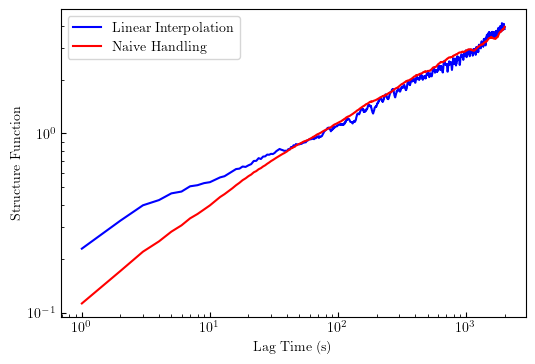

In [21]:
# Plot the SFs
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(
    bad_output["lag"],
    bad_output["sf_2"],
    label="Linear Interpolation",
    color="blue",
)

ax.plot(
    interp_output["lag"],
    interp_output["sf_2"],
    label="Naive Handling",
    color="red",
)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Lag Time (s)")
ax.set_ylabel("Structure Function")
ax.legend()

plt.show()

### Correcting SF

In [22]:
# Importing lookup table
n_bins = 25
with open(f"../results/{run_mode}/correction_lookup_3d_{n_bins}_bins_lint.pkl", "rb") as f:
    correction_lookup_3d = pickle.load(f)

## Smoothing correction

Previous method, employed in first paper submission, involved Gaussian blurring the heatmaps to create `correction_lookup_3d_blurred`, which replaced `correction_lookup_3d` in the following script. *See the GitHub, main branch, for this code.*

This time we are smoothing the actual correction values for each specific SF; this is done below and applied to the interval from the paper.


In [23]:
# Apply 2D and 3D scaling to test set, report avg errors

sfs_lint_corrected_3d = sf.compute_scaling(sfs_gapped, 3, correction_lookup_3d, n_bins)

Loaded 3D lookup table with 25 bins


In [24]:
from scipy.interpolate import interp1d


# Smoothing function
def smooth_scaling(x, y, num_bins=20):
    bin_edges = np.logspace(np.log10(x.min()), np.log10(x.max()), num_bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    y_binned = np.array(
        [
            y[(x >= bin_edges[i]) & (x < bin_edges[i + 1])].mean()
            for i in range(len(bin_edges) - 1)
        ]
    )

    # Preserve the first and last values to prevent edge distortions
    # during extrapolation
    full_bins = np.insert(bin_centers, 0, bin_edges[0])
    full_bins = np.append(full_bins, bin_edges[-1])
    full_y_binned = np.insert(y_binned, 0, y.iloc[0])
    full_y_binned = np.append(full_y_binned, y.iloc[-1])

    interp_func = interp1d(
        full_bins, full_y_binned, kind="cubic", fill_value="extrapolate"
    )
    return interp_func(x)

In [25]:
sfs_lint_corrected_3d.int_index.unique()

array([1])

In [26]:
single_sf = sfs_lint_corrected_3d[
    (sfs_lint_corrected_3d["int_index"] == int_index)
    & (sfs_lint_corrected_3d["version"] == version)
]

scaling_smooth = smooth_scaling(single_sf.lag, single_sf.scaling)
scaling_lower_smooth = smooth_scaling(single_sf.lag, single_sf.scaling_lower)
scaling_upper_smooth = smooth_scaling(single_sf.lag, single_sf.scaling_upper)

# Save to the main dataframe
sfs_lint_corrected_3d.loc[
    (sfs_lint_corrected_3d["int_index"] == int_index)
    & (sfs_lint_corrected_3d["version"] == version),
    "scaling_smooth",
] = scaling_smooth

sfs_lint_corrected_3d.loc[
    (sfs_lint_corrected_3d["int_index"] == int_index)
    & (sfs_lint_corrected_3d["version"] == version),
    "scaling_lower_smooth",
] = scaling_lower_smooth

sfs_lint_corrected_3d.loc[
    (sfs_lint_corrected_3d["int_index"] == int_index)
    & (sfs_lint_corrected_3d["version"] == version),
    "scaling_upper_smooth",
] = scaling_upper_smooth

# Apply scalings
sfs_lint_corrected_3d["sf_2_corrected_3d"] = (
    sfs_lint_corrected_3d["sf_2"] * sfs_lint_corrected_3d["scaling_smooth"]
)
sfs_lint_corrected_3d["sf_2_lower_corrected_3d"] = (
    sfs_lint_corrected_3d["sf_2"] * sfs_lint_corrected_3d["scaling_lower_smooth"]
)
sfs_lint_corrected_3d["sf_2_upper_corrected_3d"] = (
    sfs_lint_corrected_3d["sf_2"] * sfs_lint_corrected_3d["scaling_upper_smooth"]
)

In [27]:
correction_wide = sfs_lint_corrected_3d[
    [
        "file_index",
        "int_index",
        "version",
        "lag",
        "missing_percent",
        "sf_2_corrected_3d",
    ]
]
correction_long = pd.wide_to_long(
    correction_wide,
    ["sf_2"],
    i=["file_index", "int_index", "version", "lag", "missing_percent"],
    j="gap_handling",
    sep="_",
    suffix=r"\w+",
)
correction_bounds_wide = sfs_lint_corrected_3d[
    [
        "file_index",
        "int_index",
        "version",
        "lag",
        "missing_percent",
        "sf_2_lower_corrected_3d",
        "sf_2_upper_corrected_3d",
    ]
]

correction_bounds_long = pd.wide_to_long(
    correction_bounds_wide,
    ["sf_2_lower", "sf_2_upper"],
    i=["file_index", "int_index", "version", "lag", "missing_percent"],
    j="gap_handling",
    sep="_",
    suffix=r"\w+",
)

corrections_long = pd.merge(
    correction_long,
    correction_bounds_long,
    how="inner",
    on=[
        "file_index",
        "int_index",
        "version",
        "lag",
        "missing_percent",
        "gap_handling",
    ],
).reset_index()

# Adding the corrections, now as a form of "gap_handling", back to the gapped SF dataframe
sfs_gapped_corrected = pd.concat([sfs_gapped, corrections_long])

## Calculate slopes and scales
### Initialise interval-specific statistics dataframe

In [43]:
# We want a new ints_gapped_metadata dataframe that contains the metadata for the corrected SFs
ints_gapped_metadata = sfs_gapped[["file_index", "int_index", "version"]].drop_duplicates()
ints_gapped_metadata["gap_handling"] = "corrected_3d"
ints_gapped_metadata

,file_index,int_index,version,gap_handling
1.0,0,1,0,corrected_3d


### Calculate slopes and scales

In [40]:
### Calculate stats

pwrl_range = params.pwrl_range
gap_handling = "corrected_3d"

# Calculate power-law slope for 2D and 3D corrected SFs
current_int = sfs_gapped_corrected.loc[
    (sfs_gapped_corrected["file_index"] == file_index)
    & (sfs_gapped_corrected["int_index"] == int_index)
    & (sfs_gapped_corrected["version"] == version)
    & (sfs_gapped_corrected["gap_handling"] == gap_handling)
]

current_int.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1999 entries, 0.0 to 1998.0
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lag              1999 non-null   float64
 1   n                0 non-null      float64
 2   missing_percent  1999 non-null   float64
 3   sf_2             1999 non-null   float64
 4   sf_2_se          0 non-null      float64
 5   file_index       1999 non-null   int64  
 6   int_index        1999 non-null   int64  
 7   version          1999 non-null   int64  
 8   gap_handling     1999 non-null   object 
 9   sf_2_lower       1999 non-null   float64
 10  sf_2_upper       1999 non-null   float64
dtypes: float64(7), int64(3), object(1)
memory usage: 187.4+ KB


In [46]:
slope = np.polyfit(
    np.log(
        current_int.loc[
            (current_int["lag"] >= pwrl_range[0])
            & (current_int["lag"] <= pwrl_range[1]),
            "lag",
        ]
    ),
    np.log(
        current_int.loc[
            (current_int["lag"] >= pwrl_range[0])
            & (current_int["lag"] <= pwrl_range[1]),
            "sf_2",
        ]
    ),
    1,
)[0]

# Fit a power law to the corrected SF
from scipy.optimize import curve_fit


def power_law(x, a, b):
    return a * x**b

sf_corrected_es = current_int["sf_2"] * current_int["lag"] / 6

popt, pcov = curve_fit(
    power_law, 1 / current_int["lag"][100:700], sf_corrected_es[100:700]
)

# Get ACF from SF
# var_signal = np.sum(np.var(input, axis=0))
var_signal = 3
# will always be this variance as we are using the standardised 3D SF
acf_from_sf = 1 - (current_int.sf_2 / (2 * var_signal))
current_int.loc[:, "acf_from_sf"] = acf_from_sf.astype("float32")

# Calculate correlation scale from acf_from_sf
tce = utils.compute_outer_scale_exp_trick(
    current_int["lag"].values,
    current_int["acf_from_sf"].values,
    plot=False,
)
# plt.show()
# NB: if plotting, will not work if tce is not found

ttu, taylor_scale_u_std = utils.compute_taylor_chuychai(
    current_int["lag"].values,
    current_int["acf_from_sf"].values,
    tau_min=params.tau_min,
    tau_max=params.tau_max,
)

C:\Users\spann\AppData\Local\Temp\ipykernel_4356\588453951.py:29: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  power_law, 1 / current_int["lag"][100:700], sf_corrected_es[100:700]


### Save results to dataframe

In [47]:
if gap_handling != "true":
    # Save metadata to the gapped metadata df

    ints_gapped_metadata.loc[
        (ints_gapped_metadata["file_index"] == file_index)
        & (ints_gapped_metadata["int_index"] == int_index)
        & (ints_gapped_metadata["version"] == version)
        & (ints_gapped_metadata["gap_handling"] == gap_handling),
        "slope",
    ] = slope

    ints_gapped_metadata.loc[
        (ints_gapped_metadata["file_index"] == file_index)
        & (ints_gapped_metadata["int_index"] == int_index)
        & (ints_gapped_metadata["version"] == version)
        & (ints_gapped_metadata["gap_handling"] == gap_handling),
        "tce",
    ] = tce

    ints_gapped_metadata.loc[
        (ints_gapped_metadata["file_index"] == file_index)
        & (ints_gapped_metadata["int_index"] == int_index)
        & (ints_gapped_metadata["version"] == version)
        & (ints_gapped_metadata["gap_handling"] == gap_handling),
        "ttu",
    ] = ttu

    ints_gapped_metadata.loc[
        (ints_gapped_metadata["file_index"] == file_index)
        & (ints_gapped_metadata["int_index"] == int_index)
        & (ints_gapped_metadata["version"] == version)
        & (ints_gapped_metadata["gap_handling"] == gap_handling),
        "slope_es",
    ] = popt[1]

ints_gapped_metadata

,file_index,int_index,version,gap_handling,slope,tce,ttu,slope_es
1.0,0,1,0,corrected_3d,0.354636,1029.008,6.011613,-1.267333


##############################################################

## Calculate slope of equivalent spectrum of corrected SF

-1.267213819472012


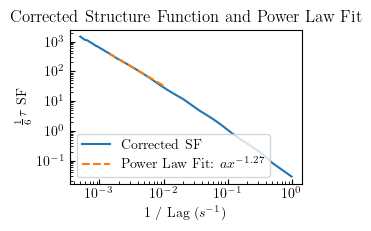

In [ ]:
# # Fit a power law to the corrected SF
# from scipy.optimize import curve_fit


# def power_law(x, a, b):
#     return a * x**b

# # Just get the corrected SF for this interval
# sf_corrected_raw = sfs_gapped_corrected.loc[
#     (sfs_gapped_corrected["file_index"] == file_index)
#     & (sfs_gapped_corrected["int_index"] == int_index)
#     & (sfs_gapped_corrected["version"] == version)
#     & (sfs_gapped_corrected["gap_handling"] == "corrected_3d"),
#     ["lag", "sf_2"],
# ]

# sf_lags = sf_corrected_raw.lag.values
# sf_corrected = sf_corrected_raw.sf_2.values
# sf_corrected_es = sf_corrected * sf_lags / 6

# popt, pcov = curve_fit(power_law, 1 / sf_lags[100:700], sf_corrected_es[100:700])

# print(popt[1])

# # Plotting the corrected structure function and the power law fit
# plt.figure(figsize=(3, 2))
# plt.loglog(1 / sf_lags, sf_corrected_es, label="Corrected SF")
# plt.loglog(
#     1 / sf_lags[100:700],
#     power_law(1 / sf_lags[100:700], *popt),
#     label=f"Power Law Fit: $a x^{{{popt[1]:.2f}}}$",
#     linestyle="--",
# )
# plt.xlabel("1 / Lag ($s^{-1}$)")
# plt.ylabel("$\\frac{1}{6} \\tau$ SF")
# plt.title("Corrected Structure Function and Power Law Fit")
# plt.legend()
# plt.show()

Let's compare with the values for the uncorrected version (JUST LOOK AT SECOND VALUE OF FIRST ARRAY)

In [30]:
# sf_corrected_raw = sfs_gapped_corrected.loc[
#     (sfs_gapped_corrected["file_index"] == file_index)
#     & (sfs_gapped_corrected["int_index"] == int_index)
#     & (sfs_gapped_corrected["version"] == version)
#     & (sfs_gapped_corrected["gap_handling"] == "lint"),
#     ["lag", "sf_2"],
# ]

# sf_corrected = sf_corrected_raw.sf_2.values
# sf_corrected_es = sf_corrected * sf_lags / 6

# curve_fit(power_law, 1 / sf_lags[100:700], sf_corrected_es[100:700])

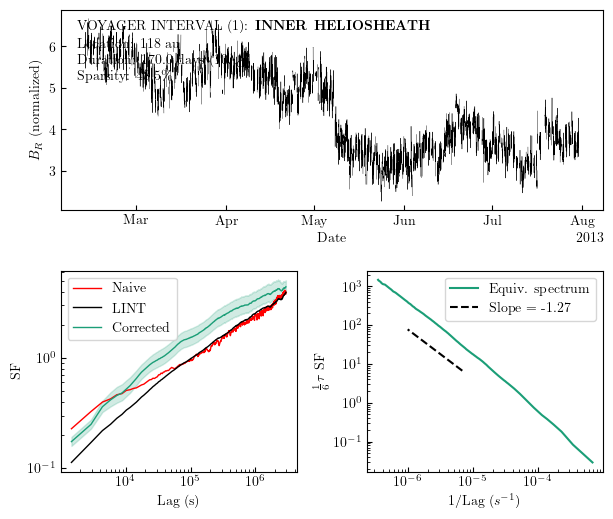

In [33]:
# fig, ax = plt.subplots(1, 3, figsize=(8, 2), constrained_layout=True)
fig = plt.figure(figsize=(7, 6))

gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])
gs.update(hspace=0.3, wspace=0.3)  # Change 0.5 to control the spacing
# First row, spanning both columns
ax1 = fig.add_subplot(gs[0, :])

# Second row, first column
ax2 = fig.add_subplot(gs[1, 0])

# Second row, second column
ax3 = fig.add_subplot(gs[1, 1])


file_index = 0
int_index = 1
version = 0

ax1.plot(bad_input.index, bad_input["BR"], color="black", lw=0.3, label="Raw")
# ax1.plot(
#     interp_input_df["Time"],
#     interp_input_df["BR"],
#     color="black",
#     lw=1,
#     label="Linearly interpolated",
# )
ax1.set_xlabel("Date")
ax1.set_ylabel(r"$B_R$ (normalized)")
ax1.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator())
)
# ax1.set_title("Magnetic field @ 154 AU (Voyager 1, interstellar medium)"),
# ax1.set_title("Magnetic field @ 118 AU (Voyager 1, inner heliosheath)")

ax1.annotate(
    f"Location: 118 au\n \
    Duration: {np.round(tc*10/(24*60*60),1)} days ($10\\lambda_C$)\n \
    Sparsity: {float(missing*100):.1f}\%",
    xy=(1, 1),
    xycoords="axes fraction",
    xytext=(0.03, 0.65),  # 0.1 / 0.65
    textcoords="axes fraction",
    transform=ax1.transAxes,
    c="black",
    # bbox=dict(facecolor="lightgrey", edgecolor="white", boxstyle="round", alpha=0.7),
)

ax1.annotate(
    r"VOYAGER INTERVAL (1): \textbf{INNER HELIOSHEATH}",
    xy=(1, 1),
    xycoords="axes fraction",
    xytext=(0.03, 0.9),  # 0.03 / 0.28
    textcoords="axes fraction",
    transform=ax1.transAxes,
    c="black",
    # bbox=dict(facecolor="lightgrey", edgecolor="white", boxstyle="round", alpha=0.7),
)

ax2.set_xlabel("Lag (s)")
ax2.set_ylabel("SF")

ax2.plot(
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "naive"),
        "lag",
    ]
    * new_cadence,
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "naive"),
        "sf_2",
    ],
    color="red",
    lw=1,
    label="Naive",
)
ax2.plot(
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "lint"),
        "lag",
    ]
    * new_cadence,
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "lint"),
        "sf_2",
    ],
    color="black",
    lw=1,
    label="LINT",
)
ax2.plot(
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "corrected_3d"),
        "lag",
    ]
    * new_cadence,
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "corrected_3d"),
        "sf_2",
    ],
    color="#1b9e77",
    lw=1,
    label="Corrected",
)
ax2.fill_between(
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "corrected_3d"),
        "lag",
    ]
    * new_cadence,
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "corrected_3d"),
        "sf_2_lower",
    ],
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "corrected_3d"),
        "sf_2_upper",
    ],
    color="#1b9e77",
    alpha=0.2,
)
ax2.legend(loc="upper left")  # lower right
ax2.semilogx()
ax2.semilogy()

# Third panel (bottom right)
ax3.plot(
    1 / (sf_lags * new_cadence),
    sf_corrected_es,
    label="Equiv. spectrum",
    c="#1b9e77",
)
ax3.plot(
    1 / (sf_lags[100:700] * new_cadence),
    power_law(1 / sf_lags[100:700], *popt) / 5,
    label="Slope = {:.2f}".format(popt[1]),
    ls="--",
    color="black",
)
ax3.semilogx()
ax3.semilogy()
ax3.legend(loc="upper right")
ax3.set_xlabel("1/Lag ($s^{-1}$)")
ax3.set_ylabel(r"$\frac{1}{6} \tau$ SF")
# plt.savefig("plots/results/final/voyager_ihs.pdf")
plt.show()